## Week 10: Image Analysis

> ### Application: Grain Size Measurement

#### Load packages

> First make sure you have cv2 installed.  Go to the anaconda power shell and run the following command: pip install opencv-contrib-python 

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import io, color, measure
import pandas as pd

from PIL import Image
from IPython.display import display

from pathlib import Path

#### Read image file. 
>Let's take a look at what data is contained in an image file.  We need this to better understand the steps below.  We will look at two types of images.  One is an RGB color image and the other is a grayscale image.  

In [31]:
#img = cv.imread("grains callister.png")
#img=img[8:270, 10:230]
img=cv.imread('grain image wo 25um bar.png')
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
img_shift=cv.pyrMeanShiftFiltering(img, 11, 21)  #acts on original image

gray=cv.cvtColor(img_shift,cv.COLOR_BGR2GRAY) #move img to gray scale
blur=cv.GaussianBlur(gray,(3,3),0) # acts on gray scale image

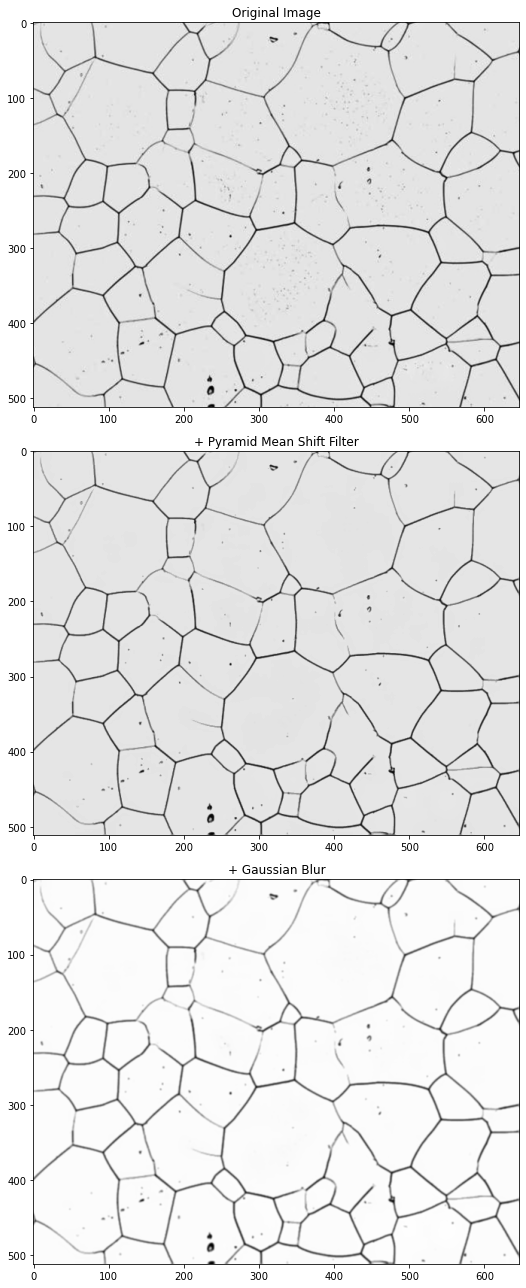

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize=(8, 18))
ax1.imshow(img)
ax2.imshow(gray, cmap='gray')
ax3.imshow(blur, cmap='gray')
ax1.set_title('Original Image')
ax2.set_title('+ Pyramid Mean Shift Filter')
ax3.set_title('+ Gaussian Blur')
plt.tight_layout()

#### Now threshold our image to black (0) & white (255) 

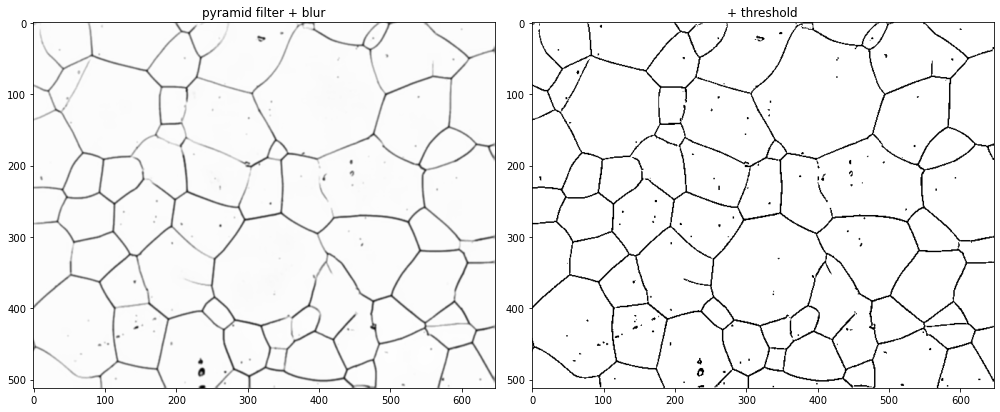

In [33]:
image_to_threshold=gray

#************** 3 choices here for performing threshold *********************
#ret, thresh = cv.threshold(image_to_threshold,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
thresh= cv.adaptiveThreshold(image_to_threshold, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY, 7, 11)
#thresh = cv.adaptiveThreshold(image_to_threshold,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,7,6) # notice using gray here not img

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14, 7))
ax1.imshow(blur, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax1.set_title('pyramid filter + blur')
ax2.set_title('+ threshold')

plt.tight_layout()

#### Now define a few images we  need to apply our watershed routine. 

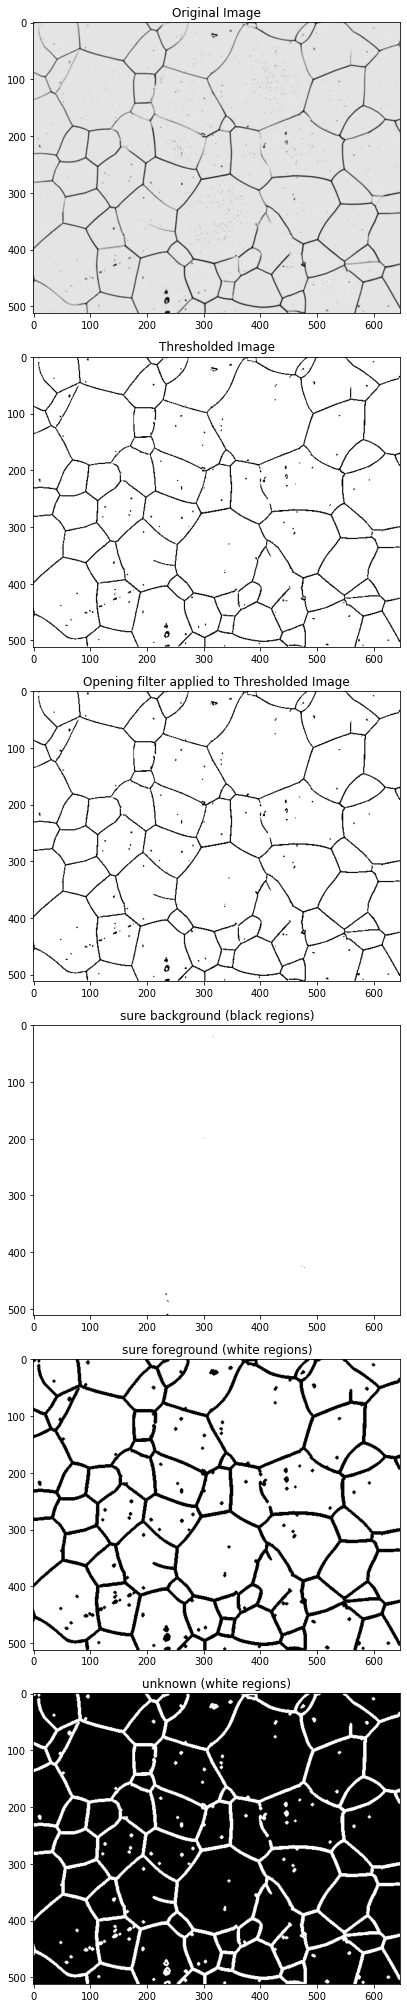

In [36]:
#kernel=cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
# kernel=cv.getStructuringElement(cv.MORPH_RECT,(3,3))

# noise removal
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations=1)

# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=2)

# Finding sure foreground area
sure_fg = cv.erode(opening,kernel,iterations=2)

# Finding unknown region
unknown = cv.subtract(sure_bg,sure_fg)


# ******************* Display results of each step ********************

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1,figsize=(8, 28))
ax1.imshow(img, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax3.imshow(opening, cmap='gray')
ax4.imshow(sure_bg, cmap='gray')
ax5.imshow(sure_fg, cmap='gray')
ax6.imshow(unknown, cmap='gray')

ax1.set_title('Original Image')
ax2.set_title('Thresholded Image')
ax3.set_title('Opening filter applied to Thresholded Image')
ax4.set_title('sure background (black regions)')
ax5.set_title('sure foreground (white regions)')
ax6.set_title('unknown (white regions)')
plt.tight_layout()

#### Label groups of connected pixels with integers (labels)

In [37]:
# Marker labelling
# cv2.connectedComponents(). labels background of the image with 0, 
#then other objects are labelled with integers starting from 1.
ret, markers = cv.connectedComponents(sure_fg)

#### Keep our markers but change the "unknown" reagions to value 0
>The watershed routine will "fill" these 0 regions with different color water starting from the cluster labels.  Where the water intersects, defines the boundary.  The boundary is set to a value of -1 and colored red.  

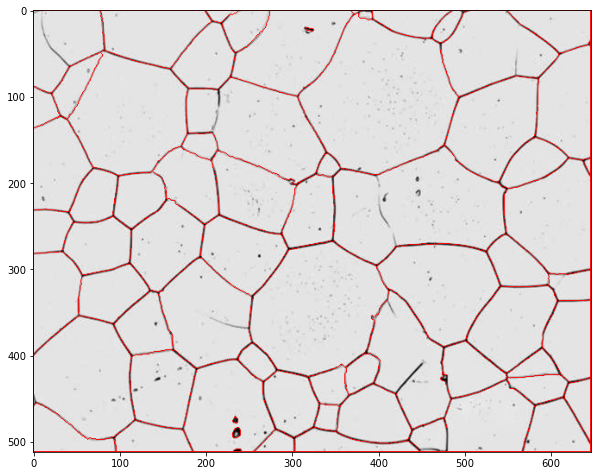

In [38]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)  # img needs shape (pix, pix, 3), markers is (pix, pix)
img[markers ==-1] = [255,0,0]

#display(Image.fromarray(markers))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot

ax.imshow(img)

plt.show()


#### Change the marker labels to colors and combine with the original image

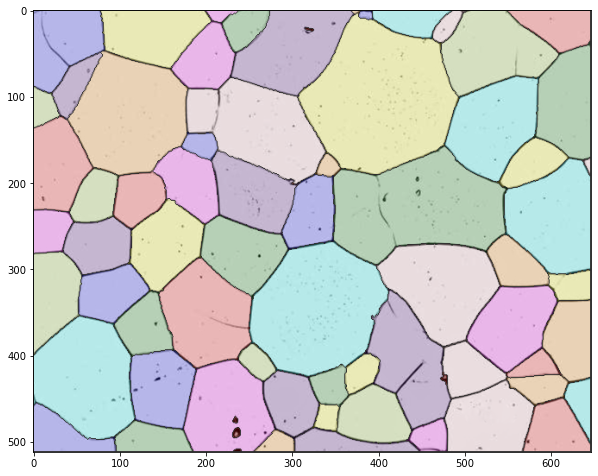

In [39]:
img2=color.label2rgb(markers, image=img, bg_label=-1, alpha=0.2)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(img2);
plt.show()

#### Each colored grain can now be analyzed and placed in a Pandas DataFrame

In [42]:
pixels_to_μm=57  # μm per pixel
propList=['label','area','equivalent_diameter','orientation','major_axis_length', 'minor_axis_length','perimeter']
#propList=['equivalent_diameter','orientation','area','major_axis_length']
props=measure.regionprops_table(markers, properties=propList)

grain_data=pd.DataFrame(props)

grain_data

,label,area,equivalent_diameter,orientation,major_axis_length,minor_axis_length,perimeter
0,1,175,14.927053,-0.377175,551.060315,390.428195,109.041631
1,3,5667,84.943796,-0.697153,106.368415,75.372413,331.823376
2,4,6151,88.496872,-1.517556,124.727847,67.176516,350.279221
3,5,274,18.677999,-1.468553,31.592302,13.374536,84.734019
4,6,1688,46.359771,-0.936150,57.305868,39.928344,176.823376
...,...,...,...,...,...,...,...
62,64,680,29.424529,-0.236250,33.037767,28.180020,116.012193
63,65,1257,40.005776,-1.363518,46.528543,36.327661,146.775649
64,66,2347,54.665283,1.522351,91.908066,34.320048,230.367532
65,67,2173,52.599900,1.497370,154.245955,23.126362,335.338095


Recall the grain size number from Callister was defined as $n=2^{G-1}$ where $n$ is the number of grains in a $1 in^2$ area at 100x and $G$ is the grain size number.  This equation could be rewritten for, $n^*$, the number of grains per $mm^2$ at no magnification.  This would be $$G = 3.322 Log(n^*)-2.9543$$

In [14]:
avg_grain_diam=(grain_data.loc[:,'equivalent_diameter'].mean()*pixels_to_μm)
print(f'Avg. Grain Diameter = {avg_grain_diam:0.2f} μm')

avg_grain_area= grain_data.loc[:,'area'].mean()*pixels_to_μm**2 #μm^2
print(f'Avg. Grain Area = {avg_grain_area:0.2f} μm^2')
n= (avg_grain_area*10**-6)**-1 # grains per mm^2
print(f'Number of grains per mm^2 = {n:0.2f}')

# Grain Size number 
print(f'Grain Size number = {3.322*np.log10(n)-2.9543:0.2f}')

Avg. Grain Diameter = 12.90 μm
Avg. Grain Area = 157.96 μm^2
Number of grains per mm^2 = 6330.52
Grain Size number = 9.67


## Homework

**1.  Pick one of the following images and find the grain size number.**  
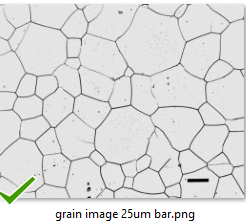
The above image can be used to get the number of pixels that equals 25 microns (black bar at bottom right).  The image below is to analyze. I removed the micron bar so it didn't affect the watershed.  
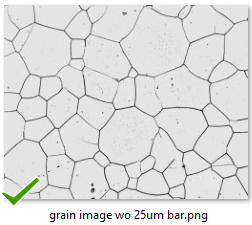
The image below has enough grains that you can just crop the micron bar out of the image and analyze the remaining grains.  
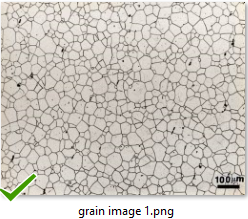
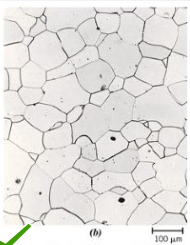

**2.  For Extra Credit and a challenge:**  Determine the fraction of proeutectoid ferrite (white regions) in this image.  The remaining areas (darker colors) is pearlite. 
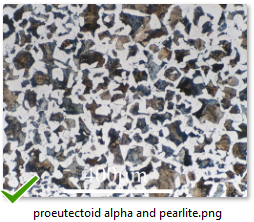